In [1]:
using AutomotiveDrivingModels
using AutoViz
using Reactive
using Interact
using NearestNeighbors
using LevelKRacing


Use "Frames{M}(...) where M" instead.
Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:64
 [2] warn_shell_special(::String) at ./shell.jl:8
 [3] #shell_parse#236(::String, ::Function, ::String, ::Bool) at ./shell.jl:103
 [4] (::Base.#kw##shell_parse)(::Array{Any,1}, ::Base.#shell_parse, ::String, ::Bool) at ./<missing>:0 (repeats 2 times)
 [5] @cmd(::ANY) at ./process.jl:796
 [6] include_from_node1(::String) at ./loading.jl:569
 [7] eval(::Module, ::Any) at ./boot.jl:235
 [8] _require(::Symbol) at ./loading.jl:483
 [9] require(::Symbol) at ./loading.jl:398
 [10] include_from_node1(::String) at ./loading.jl:569
 [11] eval(::Module, ::Any) at ./boot.jl:235
 [12] _require(::Symbol) at ./loading.jl:483
 [13] require(::Symbol) at ./loading.jl:398
 [14] include_string(::String, ::String) at ./loading.jl:515
 [15] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/kyle/.julia/v0.6/IJulia/src/execute_request.jl:156
 [16] eventloop(::ZMQ.Socket) at /Users/kyle/.julia/v0.6/IJu



Use "abstract type Camera end" instead.

Use "CarFollowCamera{I}(...) where I" instead.

Use "abstract type SceneOverlay end" instead.


# Set up racetrack

In [ ]:
# scene parameters
scene = Scene()
framerate = 24
Δt = 1.0/framerate # size of rendering timesteps

# car parameters
car_length = 4.8 # front wheel to back wheel
car_width = 2.5
v⁰  = 0.0 # initial velocity
δ⁰ = 0.0 # initial steering angle

############### INITIALIZE TRACK ################
lane_width = 30.0
radius = 45.0
edge_buffer = 0.25
T_MAX = lane_width/2.0 - car_width/2.0 - edge_buffer # max allowable projection distance from center of lane
base_speed= 0.0

# spline control points
Pts = 50*[0 -1 -2 -3 -3.5 -3 -2 -1 -0.5 -1 -2 -3 -4 -5 -6 -6.5 -6 -5.5 -6 -6 -5 -4 -3 -2 -1.5 -1 0 1 1.5 2 3 4 5 6.25 7 7 7 7 7 7 7 6 5 4 4 4 3 2 1 0; 
       0 0 0 0 -1 -2 -2 -2 -3 -4 -4 -4 -4 -4 -4 -3 -2 -1 0 1 2 3 4 4 3 2 2 2 3 4 4 4 4 4 3 2 1 0 -1 -2 -3 -4 -4 -3 -2 -1 0 0 0 0]
degree = 3 # degree of spline
num_points = 10001
num_samples = 420

track = Raceway(Pts,degree,num_points,num_samples,lane_width)
track;

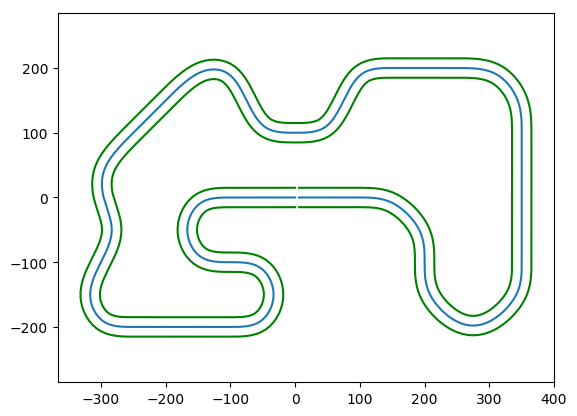

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:64
 [2] sin(::Array{Float64,1}) at ./deprecated.jl:51
 [3] plotSplineRoadway(::Array{Float64,1}, ::Array{Float64,1}, ::Array{Float64,1}, ::Float64) at /Users/kyle/.julia/v0.6/LevelKRacing/src/controllers/HierarchicalRecedingHorizonController.jl:601
 [4] include_string(::String, ::String) at ./loading.jl:515
 [5] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/kyle/.julia/v0.6/IJulia/src/execute_request.jl:156
 [6] eventloop(::ZMQ.Socket) at /Users/kyle/.julia/v0.6/IJulia/src/eventloop.jl:8
 [7] (::IJulia.##9#12)() at ./task.jl:335
while loading In[3], in expression starting on line 1
Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:64
 [2] cos(::Array{Float64,1}) at ./deprecated.jl:51
 [3] plotSplineRoadway(::Array{Float64,1}, ::Array{Float64,1}, ::Array{Float64,1}, ::Float64) at /Users/kyle/.julia/v0.6/LevelKRacing/src/controllers/HierarchicalRecedingHorizonController.jl:602
 [4] include_string(::Stri

(-366.40946119930487, 399.8290219618717, -236.50000000000003, 236.50000000000006)

In [3]:
plotSplineRoadway(track.x,track.y,track.θ,lane_width)

# Export Racetrack to csv

In [6]:
using DataArrays, DataFrames

In [19]:
dataframe = DataFrame()
fieldnames(track)

10-element Array{Symbol,1}:
 :roadway    
 :tree       
 :obstacleMap
 :models     
 :Δs         
 :x          
 :y          
 :θ          
 :k          
 :s          

In [21]:
dataframe[:x] = track.x
dataframe[:y] = track.y
dataframe[:theta] = track.θ
dataframe[:k] = track.k
dataframe[:s] = track.s

writetable("track.csv", dataframe)

# Vehicle Parameters

In [2]:
## VEHICLE PARAMETERS ##

M = 660 #kg # Vehicle mass
Iz = 450 # kgm2 # Moment of inertia about the z-axis Wheelbase
w = 3.4 # Distance of the mass centre from the front axle 
a = 1.8 # Distance of the mass centre from the rear axle 
b = w - 1 
h = 0.3 # Centre of mass height
D_roll = 0.5 # Roll moment distribution (fraction at the front axle) 
wf = 0.73 # Front wheel to car centre line distance 
wr = 0.73 # Rear wheel to car centre line distance 
R = 0.33 # Wheel radius
kd = 10.47 # Differential friction coefficient
Cd = 0.9 # Drag coefficient
Cl = 3.0 # Downforce coefficient
A = 1.5 # m2 Frontal area 
ρ = 1.2 # kg/m3 Air density
aA = 1.9 # m Centre of pressure to front axle distance 
bA = w - aA # Centre of pressure to rear axle distance

1.5

### Tire Friction Parameters

In [3]:
## TIRE FRICTION PARAMETERS ##

Fz1 = 2000 # Reference load 1
Fz2 = 6000 # Reference load 2
µx1 = 1.75 # Peak longitudinal friction coefficient at load 1 
µx2 = 1.40 # Peak longitudinal friction coefficient at load 2 
κ1 = 0.11 # Slip coefficient for the friction peak at load 1 
κ2 = 0.10 # Slip coefficient for the friction peak at load 2 
µy1 = 1.80 # Peak lateral friction coefficient at load 1 
µy2 = 1.5 # Peak lateral friction coefficient at load 2
α1 = 9 # Slip angle for the friction peak at load 1 
α2 = 8 # Slip angle for the friction peak at load 2
Qx = 1.9 # Longitudinal shape factor 
Qy = 1.9 # Lateral shape factor

1.9